In [17]:
import s2_py as s2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapefile as shp
import geopandas as gpd
import descartes
from shapely.geometry import Polygon, mapping, Point
from sklearn.metrics.pairwise import euclidean_distances

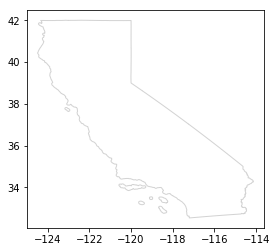

In [35]:
moisture_data_file = "../w210_Wildfire/data/FuelMoistureCA.xlsx"
moisture_sites_file = "../w210_Wildfire/data/FuelMoistureSites.xlsx"
cal_shape_file = "../w210_Wildfire/EDA/Data/CA_State/CA_State_TIGER2016.shp"

ca_df = gpd.read_file(cal_shape_file)
crs = {'init': 'epsg:4326'}
ca_df = ca_df.to_crs(crs)
ca_df.plot(color='white', edgecolor='lightgrey')


In [3]:
def create_S2_coverer(loop, lvl):
    """Generates a list of S2 Cells of specified level"""
    coverer = s2.S2RegionCoverer()
    coverer.set_min_level(lvl)
    coverer.set_max_level(lvl)
    return coverer.GetCovering(loop)

def create_S2_loop(max_poly):
    """Converts Polygon into S2 Loop"""
    points = []
    for coord in tuple(reversed(max_poly)):
        long, lat = coord
        latlng = s2.S2LatLng.FromDegrees(lat, long)
        points.append(latlng.ToPoint())
    return s2.S2Loop(points)

def extract_max_polygon(fire_poly):
    """Return the largest polygon for each wildfire multipolygon"""
    fire_map = mapping(fire_poly)
    if 'coordinates' in fire_map:
        coords = fire_map['coordinates']
    elif 'features' in fire_map:
        coords = fire_map['features'][0]['geometry']['coordinates']
    
    max_poly = coords[0][0]
    for i in range(len(coords)):
        if len(coords[i][0]) > len(max_poly):
            max_poly = coords[i][0]
    return max_poly


def S2Cells_To_GPD(covering):
    geoms = []
    for cellid in covering:
        new_cell = s2.S2Cell(cellid)
        vertices = []
        for i in range(4):
            vertex = new_cell.GetVertex(i)
            latlng = s2.S2LatLng(vertex)
            vertices.append((latlng.lng().degrees(),
                             latlng.lat().degrees()))
        geo = Polygon(vertices)
        geoms.append(geo)
    return gpd.GeoDataFrame(crs={'init': 'epsg:4326'}, geometry=geoms)


In [4]:
# Now we can extract only the largest polygon to build S2 Cells.
ca_df['Largest_polygon'] = ca_df.geometry.apply(extract_max_polygon)
ca_df.head()
# Now we can create an object called S2 loop based on that polygon's coordinates
ca_df['S2_Loop'] = ca_df.Largest_polygon.apply(create_S2_loop)

ca_df['S2_Cells'] = ca_df.S2_Loop.apply(create_S2_coverer, args=[11])

ca_s2_df = S2Cells_To_GPD(ca_df['S2_Cells'][0])
ca_s2_df.head()

#Get the centroid of each s2 cell
ca_s2_df['centroid'] = ca_s2_df.geometry.apply(lambda x : Point(x.centroid))

### Bring in the Fuel Moisture Data

In [36]:
moisture_data_file = "../w210_Wildfire/data/FuelMoistureCA.xlsx"
moisture_sites_file = "../w210_Wildfire/data/FuelMoistureSites.xlsx"

moisture_data_df = pd.read_excel(moisture_data_file)
moisture_sites_df = pd.read_excel(moisture_sites_file)

print(moisture_data_df.shape)
moisture_data_df.set_index('Site',inplace=True,drop=True)

moisture_data = moisture_sites_df.join(moisture_data_df,'site',how='right')
# Create Shapely Point objects from the lat lng
moisture_sites_df['geometry'] = moisture_sites_df.apply(lambda x : Point(x['lng'],x['lat']),axis=1)
# Convert to GeoPandas Df
gdf = gpd.GeoDataFrame(moisture_sites_df, crs=crs)

(48161, 7)


In [37]:
def closest_station(stations,s2_cells):
    X = stations[['lng','lat']].values
    Y = np.array(s2_cells.centroid.apply(lambda x : np.array([x.x,x.y])))
    
    return stations.iloc[euclidean_distances(np.stack(X),np.stack(Y)).argmin(axis=0)].site
    
dists = closest_station(moisture_sites_df,ca_s2_df)

In [38]:
print(dists.head())
print(moisture_sites_df[moisture_sites_df['site'] == 'Lava Beds Average'])
print(ca_s2_df.head())

65    Lava Beds Average
65    Lava Beds Average
65    Lava Beds Average
65    Lava Beds Average
15        Blue Mountain
Name: site, dtype: object
                 site  gacc state                         grup      lat  \
65  Lava Beds Average  NOCC    CA  Lava Beds National Monument  41.7075   

           lng                          geometry  
65 -121.484722  POINT (-121.48472222222 41.7075)  
                                            geometry  \
0  POLYGON ((-121.5151832932889 42.02787309660572...   
1  POLYGON ((-121.4807815669189 41.99995397496993...   
2  POLYGON ((-121.4333590341894 42.01438074658554...   
3  POLYGON ((-121.3859165013814 42.02878753417956...   
4  POLYGON ((-121.1276476762897 42.03003809931563...   

                                       centroid  
0  POINT (-121.5216916318696 42.00668572592214)  
1  POINT (-121.4873005326221 41.97878451432724)  
2  POINT (-121.4399025659317 41.99320638972365)  
3  POINT (-121.3924846137877 42.00760830877103)  
4  POINT (-121

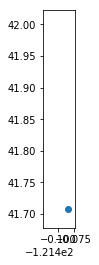

In [49]:
gdf[gdf.site == 'Lava Beds Average'].plot()
plt.plot(ca_s2_df.centroid.head().values[0].x,ca_s2_df.centroid.head().values[0].y)